In [56]:
%load_ext autoreload
%autoreload 2
from datasets import load_dataset
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from scipy.sparse import hstack
import nltk as nltk
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import numpy as np
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from IPython.display import clear_output
import matplotlib.pyplot as plt
from gensim.matutils import any2sparse
from gensim.models import LdaModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adnan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\adnan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\adnan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [57]:
# Loading files
train_files = [
    'data/FiQA_ABSA_task1/task1_headline_ABSA_train.json',
    'data/FiQA_ABSA_task1/task1_post_ABSA_train.json'
]

In [58]:
## Loading data from JSON
import json

def load_fiqa_sa_from_json(json_files):
    train_text = []
    train_labels = []

    for file in json_files:
        with open(file, 'r', encoding='UTF-8') as handle:
            dataf = json.load(handle)
        dataf_text = [dataf[k]["sentence"] for k in dataf.keys()]
        train_text.extend(dataf_text)
        dataf_labels = [float(dataf[k]["info"][0]["sentiment_score"]) for k in dataf.keys()]
        train_labels.extend(dataf_labels)
    train_text = np.array(train_text)
    train_labels = np.array(train_labels)
    return train_text, train_labels


def threshold_scores(scores):
    """
    Convert sentiment scores to discrete labels.
    0 = negative.
    1 = neutral.
    2 = positive.
    """
    labels = []
    for score in scores:
        if score < -0.2:
            labels.append(0)
        elif score > 0.2:
            labels.append(2)
        else:
            labels.append(1)
            
    return np.array(labels)


all_text, all_labels = load_fiqa_sa_from_json(train_files)
    
print(f'Number of instances: {len(all_text)}')
print(f'Number of labels: {len(all_labels)}')

all_labels = threshold_scores(all_labels)
print(f'Number of negative labels: {np.sum(all_labels==0)}')
print(f'Number of neutral labels: {np.sum(all_labels==1)}')
print(f'Number of positive labels: {np.sum(all_labels==2)}')

Number of instances: 1111
Number of labels: 1111
Number of negative labels: 310
Number of neutral labels: 195
Number of positive labels: 606


In [59]:
# Split the data into training, validation, testing sets.

from sklearn.model_selection import train_test_split

# Split test data from training data
train__docs, test__docs, train_labels, test_labels = train_test_split(
    all_text, 
    all_labels, 
    test_size=0.2, 
    stratify=all_labels
)

# Split validation data from training data
train__docs, val_documents, train_labels, val_labels = train_test_split(
    train__docs, 
    train_labels, 
    test_size=0.2, 
    stratify=train_labels
)

print(f'Number of training instances = {len(train__docs)}')
print(f'Number of validation instances = {len(val_documents)}')
print(f'Number of test instances = {len(test__docs)}')


Number of training instances = 710
Number of validation instances = 178
Number of test instances = 223


In [60]:
# Print example doc
print(f'What does one instance look like from the training set? \n\n{train__docs[234]}')
print(f'...and here is its corresponding label \n\n{train_labels[234]}')

What does one instance look like from the training set? 

Deutsche Bank Downgraded Starbucks Co. $SBUX https://t.co/QqlEvVwPMV https://t.co/f2PdQjuTHa
...and here is its corresponding label 

0


# 1. Preprocessing using  lemmatization
We create a lemmatizer tokenizer that reduces words to their root forms. This reduces the vocabulary size.

In [61]:
# We create a lemmaTokenizer class that applies lemmatization when tokenizing.
class LemmaTokenizer(object):
    
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        
    def __call__(self, _docs):
        return [self.wnl.lemmatize(self.wnl.lemmatize(self.wnl.lemmatize(tok, pos='n'), pos='v'), pos='a') for tok in word_tokenize(_docs)]
    

# 2.1 Using bi-grams + unigrams as feature
We apply our tokenizer and set it to allow ngram features (both unigrams and bigrams). 

In [62]:
vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(), ngram_range=(1,2))
vectorizer.fit(train__docs)
X_train = vectorizer.transform(train__docs)
X_val = vectorizer.transform(val_documents)
X_test__docs = vectorizer.transform(test__docs)
# Let's look at some of the features.
print(list(vectorizer.vocabulary_)[:10])

C:\Users\adnan\anaconda3\envs\data_analytics\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['$', 'cdti', 'bounce', 'here', 'on', 'support', 'or', 'h', '&', 's']


In [63]:
# Checking full vocabulary size:
print(f' Full vocabulary size: {len(vectorizer.vocabulary_)}')
vocabulary = vectorizer.vocabulary_

 Full vocabulary size: 10769


              precision    recall  f1-score   support

           0       0.78      0.58      0.67        50
           1       0.50      0.10      0.16        31
           2       0.64      0.90      0.75        97

    accuracy                           0.67       178
   macro avg       0.64      0.52      0.53       178
weighted avg       0.66      0.67      0.62       178



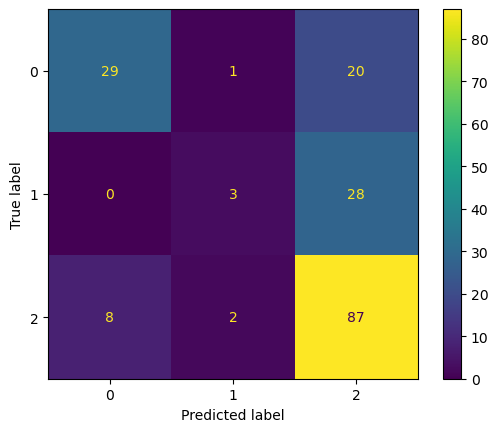

In [64]:
# Now let's fit our data to the model.
classifier = LogisticRegression()
classifier.fit(X_train, train_labels)
y_val_pred = classifier.predict(X_val)
cm = confusion_matrix(val_labels, y_val_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
print(classification_report(val_labels, y_val_pred))

# Using POS-NEG lexicon features

In [65]:
# instantiate analyzer
analyser = SentimentIntensityAnalyzer()
# fetch vocabulary
vocabulary = vectorizer.vocabulary_
# create empy holders for lexicon scores.
lexicon_pos_scores = np.zeros((1, len(vocabulary)))
lexicon_neg_scores = np.zeros((1, len(vocabulary)))

for i, term in enumerate(vocabulary):
    if term in analyser.lexicon and analyser.lexicon[term] > 0:
        lexicon_pos_scores[0, i] = 1
    elif term in analyser.lexicon and analyser.lexicon[term] < 0:
        lexicon_neg_scores[0, i] = 1

In [66]:
# This enables us to get the total positive and total negative counts for each set:
lexicon_pos_train = np.sum(X_train.multiply(lexicon_pos_scores), axis=1)
lexicon_pos_val = np.sum(X_val.multiply(lexicon_pos_scores), axis=1)
lexicon_pos_test = np.sum(X_test__docs.multiply(lexicon_pos_scores), axis=1)

lexicon_neg_train = np.sum(X_train.multiply(lexicon_neg_scores), axis=1)
lexicon_neg_val = np.sum(X_val.multiply(lexicon_neg_scores), axis=1)
lexicon_neg_test = np.sum(X_test__docs.multiply(lexicon_neg_scores), axis=1)

In [67]:
X_train = hstack((X_train, lexicon_pos_train, lexicon_neg_train))
X_val = hstack((X_val, lexicon_pos_val, lexicon_neg_val))
X_test__docs = hstack((X_test__docs, lexicon_pos_test, lexicon_neg_test))

              precision    recall  f1-score   support

           0       0.78      0.62      0.69        50
           1       0.50      0.10      0.16        31
           2       0.65      0.89      0.75        97

    accuracy                           0.67       178
   macro avg       0.64      0.53      0.53       178
weighted avg       0.66      0.67      0.63       178



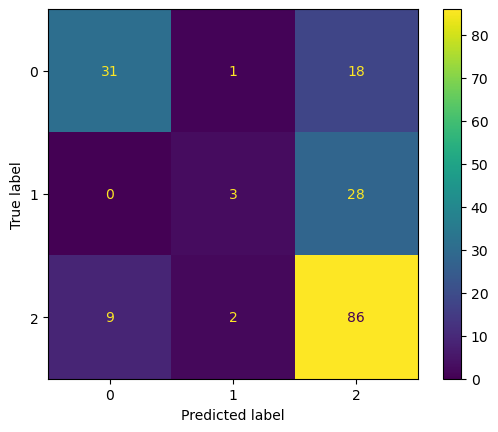

In [68]:
classifier = LogisticRegression()
classifier.fit(X_train, train_labels)
y_val_pred = classifier.predict(X_val)
# Checking performance
cm = confusion_matrix(val_labels, y_val_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
print(classification_report(val_labels, y_val_pred))

In [69]:
# Key part is investigating the errors by looking at the actual values, so let's do that:
error_indexes = y_val_pred != val_labels  # let's compare predictions to true values for labels

# get the _docs where the classifier made an error:
_docs_err = np.array(val_documents)[error_indexes]

pred_err = y_val_pred[error_indexes]
true_err = np.array(val_labels)[error_indexes]

for i in range(10):
    print(f'doc: {_docs_err[i]}; true label = {true_err[i]}, prediction = {pred_err[i]}.')

doc: End Of Day Scan: Stochastic Overbought $JDST $FREE $BLRX $LPG $AFSI $DVAX $HDGE $AHT $ALR $ASMB  www.dailystockplays.com; true label = 0, prediction = 2.
doc: On #FEDDAY looking for a sharp move up in equities $AAPL $HD $LOW $FB seeing $UVXY $TVIX getting hammered, even though market is down.; true label = 2, prediction = 0.
doc: City spirits sink after Diageo comes up short with sales slide; true label = 0, prediction = 2.
doc: FTSE 100 flat; Standard Chartered leads risers; true label = 2, prediction = 0.
doc: REFILE-Aviva Investors to move 34 bln euros in assets from AXA fund arm; true label = 0, prediction = 2.
doc: $SKX turning. Coming from far could go far. Stock price implies you pay nothing for the business; true label = 2, prediction = 0.
doc: $SAP Q1 disappoints as #software licenses down. Real problem? #Cloud growth trails $MSFT $ORCL $GOOG $CRM $ADBE https://t.co/jNDphllzq5; true label = 0, prediction = 2.
doc: $NVDA sideways; true label = 1, prediction = 2.
doc: #Appl

# Performance on test set

              precision    recall  f1-score   support

           0       0.66      0.50      0.57        62
           1       0.56      0.23      0.33        39
           2       0.69      0.90      0.78       122

    accuracy                           0.67       223
   macro avg       0.64      0.54      0.56       223
weighted avg       0.66      0.67      0.64       223



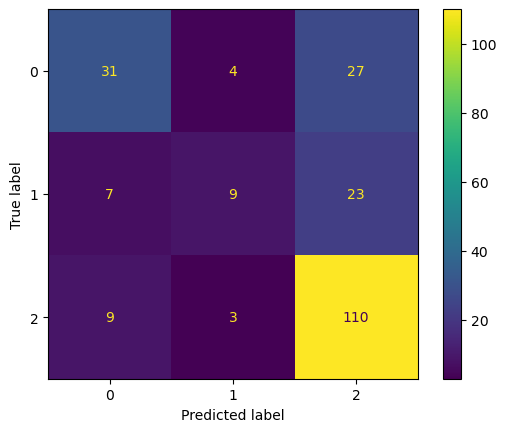

In [70]:
# Let's test the performance on the test set.
y_test_pred = classifier.predict(X_test__docs)
# Checking performance
cm = confusion_matrix(test_labels, y_test_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
print(classification_report(test_labels, y_test_pred))

# 4. Extracting topics using LDA

In [71]:
# First let's get another clean split of the data. 
from sklearn.model_selection import train_test_split

# Split test data from training data
train__docs, test__docs, train_labels, test_labels = train_test_split(
    all_text, 
    all_labels, 
    test_size=0.2, 
    stratify=all_labels
)

# Split validation data from training data
train__docs, val__docs, train_labels, val_labels = train_test_split(
    train__docs, 
    train_labels, 
    test_size=0.2, 
    stratify=train_labels 
)

print(f'Number of training instances = {len(train__docs)}')
print(f'Number of validation instances = {len(val__docs)}')
print(f'Number of test instances = {len(test__docs)}')


Number of training instances = 710
Number of validation instances = 178
Number of test instances = 223


In [72]:
 # We use the function below for tokenization. Does a number of things, including removing small words, deleting words with special chars,  changing uppercase to lowercase, and more.
def preprocess(text):
    final_results=[]
    for token in simple_preprocess(text) : 
        if token not in STOPWORDS:
            final_results.append(WordNetLemmatizer().lemmatize(token, 'v'))
    return final_results

# Create a list of preprocessed documents
processed = []
for doc in train__docs:
    processed.append(preprocess(doc))
print(processed)

[['aapl', 'break', 'downtrend', 'dma', 'prove', 'stiff', 'resistance', 'short', 'term', 'https', 'vlzlgvihzv'], ['smh', 'get', 'sell', 'signal', 'need', 'higher', 'head', 'lower', 'gap'], ['whitbread', 'boss', 'andy', 'harrison', 'defend', 'sales', 'fall', 'blip'], ['conagra', 'name', 'hillshire', 'farm', 'ceo', 'connolly', 'post'], ['nflx', 'vision', 'short', 'term', 'consolidation', 'movement', 'higher', 'http', 'stks', 'uu'], ['tesla', 'motor', 'recall', 'model', 'suvs', 'https', 'bfws', 'dbm', 'tsla'], ['aviva', 'suspend', 'property', 'fund', 'investors', 'panic'], ['tesco', 'share', 'price', 'dip', 'blinkbox', 'book', 'close', 'end', 'supermarket', 'digital'], ['vxx', 'start', 'creep', 'spy', 'sit', 'near', 'hod'], ['ea', 'point', 'facebook', 'game', 'accuse', 'znga', 'copyright', 'infringement', 'http', 'stks'], ['gs', 'look', 'weak', 'market', 'move', 'higher', 'good', 'sign', 'gs', 'early', 'short', 'today'], ['dgi', 'technical', 'alert', 'gilligan', 'island', 'buy', 'setup', '

In [73]:
from gensim.corpora import Dictionary
# create a dictionary of word:id key/val pairs.
dictionary = Dictionary(processed) 
print(dictionary)

bow_corpus = [dictionary.doc2bow(doc) for doc in processed]

Dictionary(2381 unique tokens: ['aapl', 'break', 'dma', 'downtrend', 'https']...)


In [74]:
# Getting means of thetas and training the LDA.



lda_model =  LdaModel(bow_corpus, 
                      num_topics=10, 
                      id2word=dictionary,                                    
                      passes=10,
                    ) 

def get_doc_topic_dists(_docs, lda_model):
    thetas = []
    for i in range(len(_docs)):
        # Get the doc
        unseen_doc = _docs[i]

        # Preprocess for bag of words:
        bow_vector = dictionary.doc2bow(preprocess(unseen_doc))

        # Let's get the topic distribution:
        theta_doc = lda_model[bow_vector]

        thetas.append(theta_doc)

    return thetas

thetas = get_doc_topic_dists(val__docs, lda_model)

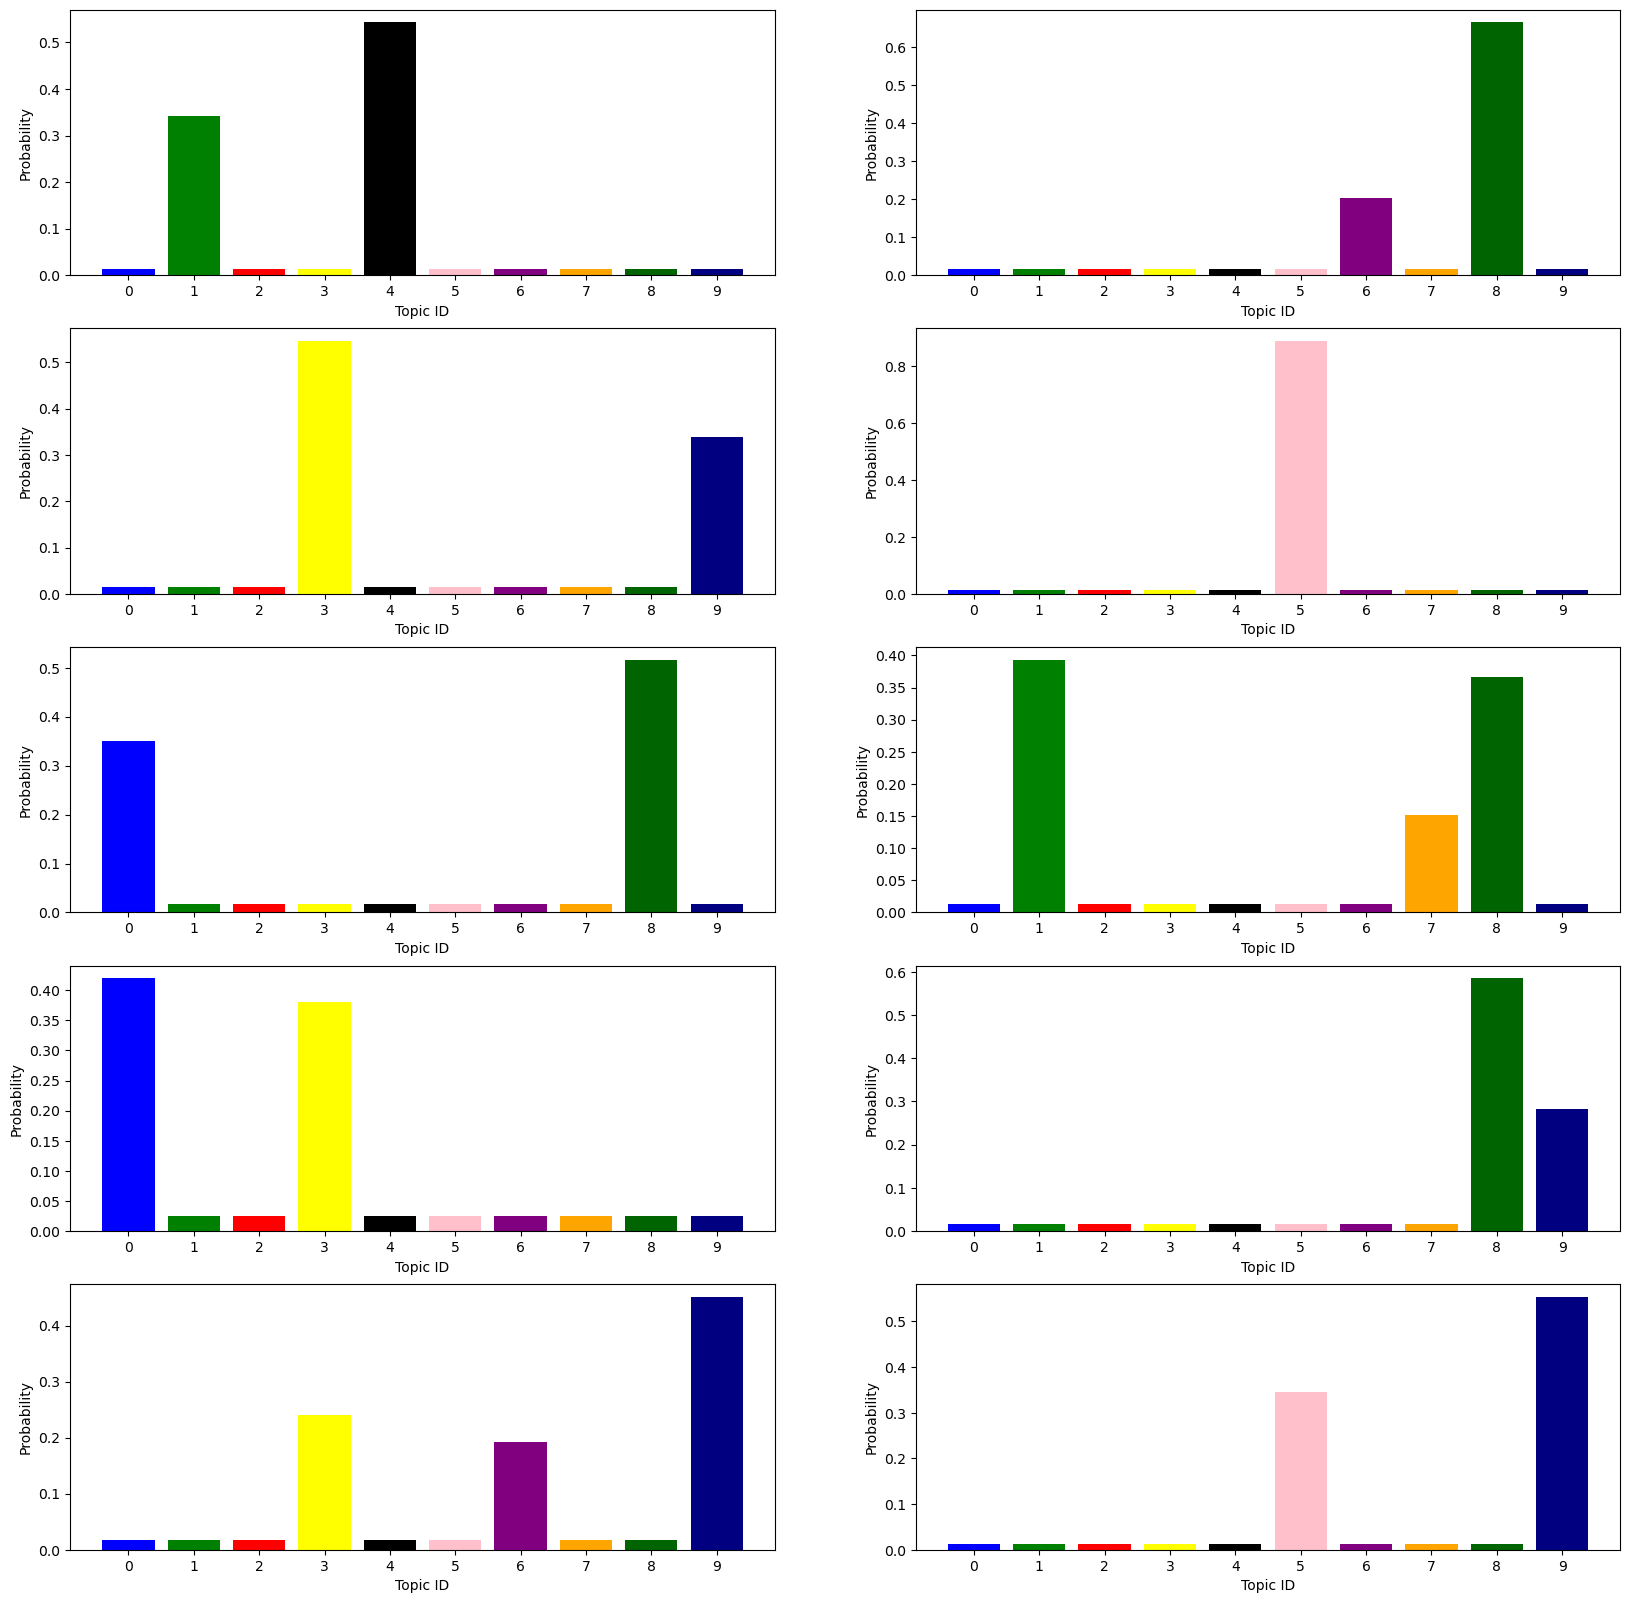

In [75]:

# We will use colours to represent topics.
colours = ['blue', 'green', 'red', 'yellow', 'black', 'pink', 'purple',
           'orange',  'darkgreen',  'navy', 'crimson']

def convert_theta_sparse_to_dense_vector(theta_dist_sparse, num_topics):
    theta_dist = np.zeros(num_topics)
    
    # get active topics
    active_topics_for_dist, probs = map(list, zip(*theta_dist_sparse))
    
    # add to thetas_dist
    for i, topic in enumerate(active_topics_for_dist):
        if topic >= num_topics:
            break
            
        theta_dist[topic] = probs[i]
    
    return theta_dist

# Create barchart
def plot_theta(thetas, i, num__docs, num_topics):
    plt.subplot(int((num__docs+1)/2), 2, i+1)
    theta_dist = convert_theta_sparse_to_dense_vector(thetas[i], num_topics)
    plt.bar(x=np.arange(len(theta_dist)), height=theta_dist, color=colours, tick_label=np.arange(num_topics))
    plt.xlabel("Topic ID")
    plt.ylabel("Probability")
plt.figure(figsize=(20,20))

num__docs = 10
num_topics = 10
counter = 0
for i, theta in enumerate(thetas):
    if (counter < 10):
        plot_theta(thetas, i, num__docs, num_topics)
        counter +=1
plt.show()

# Visualizing topic distributions across labels using validation set

In [76]:
# Merge arrays for later 
arr = val__docs
arr_2 = val_labels

arrays = [arr,arr_2]
new_arr = np.stack(arrays, axis=1)
print(new_arr[new_arr[:,1] =='1'])

[['Sanofi poaches AstraZeneca scientist as new research head' '1']
 ['METALS-Zinc surges 12 pct after Glencore cuts output, fuelling metals rally'
  '1']
 ['Tesco breaks its downward slide by cutting sales decline in half' '1']
 ["$AAPL Now I'm glad I got stopped out of my $113 weeklies when I did. Will re-enter next Monday for the #earnings run-up."
  '1']
 ['AB InBev offers SABMiller $3 billion breakup fee' '1']
 ['4 beaten-down Internet companies that may be ripe for a #takeover target: #Twitter $TWTR - #LinkedIn $LNKD - #Yahoo! $YHOO - #Groupon $GRPN'
  '1']
 ['U.S. Debt Lures Schroders as ECB Depresses Rates' '1']
 ['Intertek Group announces strategic update outlining its plan' '1']
 ['Shell share price: Standard Life announce position against BG acquisition'
  '1']
 ["Barclays appoints JPMorgan's Paul Compton as new COO" '1']
 ['$GILD Sandbagged the guidance so the can use that last 3 billion up.  CC was cautiously optimistic, wait til Next ER for confirmation'
  '1']
 ['HSBC app

In [77]:
# Show numbers till 8 decimal points for debugging.
np.set_printoptions(precision=8)
def get_doc_mean_topics():
    # Create a matrix where each row corresponds to a label
    mean_thetas = np.zeros((len(['0','1','2']), 10))
    label_arr = ['0','1','2']
    for label in label_arr:
        # call get_doc_topic_dists
        thetas_t_sparse = get_doc_topic_dists(val__docs[new_arr[:,1] ==label], lda_model)
        # convert to a dense vector
        thetas_t = []
        for theta_dist_t_sparse in thetas_t_sparse:
            if not theta_dist_t_sparse:
                continue
            thetas_dist = convert_theta_sparse_to_dense_vector(theta_dist_t_sparse, 10)
            thetas_t.append(thetas_dist)
        # Get the mean theta
        mean_theta_t = np.mean(thetas_t, axis=0)
        mean_thetas[int(label)] = mean_theta_t
        print(mean_thetas[int(label)])
    return mean_thetas
   
mean_arr = get_doc_mean_topics()

print(mean_arr.shape)

[0.0631632  0.15447315 0.077604   0.048887   0.09179244 0.13108254
 0.0570325  0.10030229 0.13169926 0.14187282]
[0.04108642 0.0320041  0.04821305 0.09150083 0.10557475 0.11215669
 0.15099244 0.1237546  0.12553411 0.16434166]
[0.06365217 0.0948917  0.0570497  0.0831675  0.07584227 0.12773875
 0.07742795 0.11709149 0.14558053 0.1532406 ]
(3, 10)


[0.06556411 0.14927104 0.0636857  0.06411515 0.07827978 0.13106882
 0.05703679 0.08989631 0.14226384 0.15672767]
[0.04108593 0.03200117 0.04820173 0.09151719 0.10557609 0.11234565
 0.15098695 0.12375498 0.12554939 0.16413957]
[0.06801241 0.10252936 0.04771661 0.08827954 0.07520871 0.12110565
 0.07839782 0.11488439 0.14511905 0.15442912]


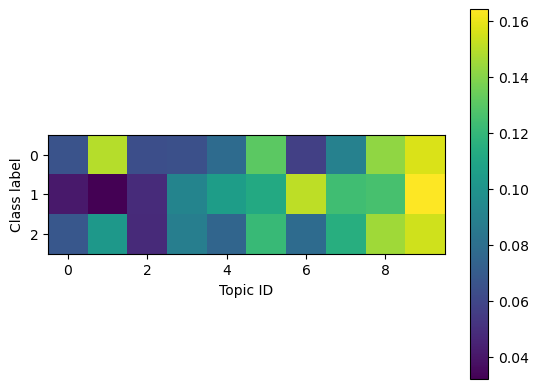

In [78]:
def plot_doc_topic_matrix():
    # Get mean doc topics dists
    mean_thetas = get_doc_mean_topics()
    # Let's show a heatmap to see which topics occur the most for different labels
    plt.imshow(mean_thetas)
    plt.colorbar()
    plt.xlabel("Topic ID")
    plt.ylabel("Class label")
    plt.show()
plot_doc_topic_matrix()

In [79]:
# For each topic, let's show the words occuring in that topic, so we can identify it.
for topic_id, topic in lda_model.print_topics(-1):
    print("Topic ID: {} \nAssociated Words:\n {}".format(topic_id, topic ))
    print("\n")

Topic ID: 0 
Associated Words:
 0.009*"shire" + 0.009*"share" + 0.007*"long" + 0.007*"stks" + 0.007*"http" + 0.007*"baxalta" + 0.007*"price" + 0.005*"barclays" + 0.005*"ceo" + 0.005*"update"


Topic ID: 1 
Associated Words:
 0.021*"http" + 0.020*"stks" + 0.013*"buy" + 0.011*"plc" + 0.011*"astrazeneca" + 0.011*"drug" + 0.009*"fall" + 0.008*"https" + 0.007*"price" + 0.007*"share"


Topic ID: 2 
Associated Words:
 0.014*"short" + 0.011*"aapl" + 0.010*"bank" + 0.008*"http" + 0.008*"break" + 0.008*"stks" + 0.008*"shell" + 0.007*"https" + 0.007*"new" + 0.007*"loss"


Topic ID: 3 
Associated Words:
 0.024*"https" + 0.014*"inbev" + 0.011*"ab" + 0.011*"sabmiller" + 0.011*"buy" + 0.010*"fb" + 0.009*"long" + 0.008*"billion" + 0.007*"tsla" + 0.007*"amzn"


Topic ID: 4 
Associated Words:
 0.009*"dividend" + 0.009*"long" + 0.008*"sales" + 0.008*"rise" + 0.007*"share" + 0.007*"stks" + 0.007*"http" + 0.007*"update" + 0.006*"https" + 0.006*"post"


Topic ID: 5 
Associated Words:
 0.022*"http" + 0.020*"

# Using test set

[['UPDATE 3-Stifel to buy former Lehman brokerage from Barclays' '1']
 ['$RAD All my charts are flashing oversold.' '1']
 ['BG Group appoints new CEO one month early' '1']
 ["$aapl key is to breakout above 460 on solid volume or else it's a no trade for now"
  '1']
 ["Morning Agenda: Shire's Deal for NPS" '1']
 ['$COST Costco less than stellar day but it held the 50 day moving average'
  '1']
 ['Irish Said Chasing Standard Chartered, RBS as Brexit Vote Nears' '1']
 ['UPDATE: CIB, Legal & General Sell Egyptian Life Joint Venture To AXA'
  '1']
 ['Entertainment One dispels ITV takeover rumours' '1']
 ['New Credit Suisse boss faces stiff challenge in Asia' '1']
 ['$CNP Sell Short Position on CNP,...Closed for Profit $ 59,367.00 (7.75%) http://stks.co/ghjc'
  '1']
 ['CompaniesHoward Davies appointment as RBS director delayed' '1']
 ["ITV to pursue takeover of Canada's Entertainment One: Bloomberg" '1']
 ['$AAPL broke descending channel....will it hold?' '1']
 ['Tesco Abandons Video-Streami

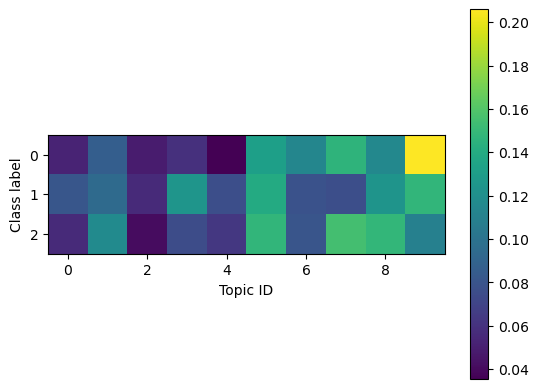

In [80]:
# Merge arrays for later 
arr = test__docs
arr_2 = test_labels

arrays = [arr,arr_2]
new_arr = np.stack(arrays, axis=1)
print(new_arr[new_arr[:,1] =='1'])

# Show numbers till 8 decimal points for debugging.
np.set_printoptions(precision=8)
def get_doc_mean_topics():
    # Create a matrix where each row corresponds to a label
    mean_thetas = np.zeros((len(['0','1','2']), 10))
    label_arr = ['0','1','2']
    for label in label_arr:
        # call get_doc_topic_dists
        thetas_t_sparse = get_doc_topic_dists(test__docs[new_arr[:,1] ==label], lda_model)
        # convert to a dense vector
        thetas_t = []
        for theta_dist_t_sparse in thetas_t_sparse:
            if not theta_dist_t_sparse:
                continue
            thetas_dist = convert_theta_sparse_to_dense_vector(theta_dist_t_sparse, 10)
            thetas_t.append(thetas_dist)
        # Get the mean theta
        mean_theta_t = np.mean(thetas_t, axis=0)
        mean_thetas[int(label)] = mean_theta_t
        print(mean_thetas[int(label)])
    return mean_thetas
   
mean_arr = get_doc_mean_topics()

def plot_doc_topic_matrix():
    # Get mean doc topics dists
    mean_thetas = get_doc_mean_topics()
    # Let's show a heatmap to see which topics occur the most for different labels
    plt.imshow(mean_thetas)
    plt.colorbar()
    plt.xlabel("Topic ID")
    plt.ylabel("Class label")
    plt.show()
plot_doc_topic_matrix()